# Word2vec

## Theory

Word2Vec is vector representation of word. The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.

A simple way to investigate the learned representations is to find the closest words for a user-specified word. The distance tool serves that purpose. For example, if you enter 'france', distance will display the most similar words and their distances to 'france', which should look like:

```

Word Cosine distance

            spain              0.678515
          belgium              0.665923
      netherlands              0.652428
            italy              0.633130
      switzerland              0.622323
       luxembourg              0.610033
         portugal              0.577154
           russia              0.571507
          germany              0.563291
        catalonia              0.534176
```

There are two main learning algorithms in word2vec : continuous bag-of-words and continuous skip-gram. Both algorithms learn the representation of a word that is useful for prediction of other words in the sentence.
Skipgram - predict context words given the target (position independent)
CBoW - predict target word from the bag of words context

Training Methods - Hierarchical Softmax and Negative Sampling

Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words


#### Facts:
<li>Predictive method, not a count-based as Glove or BagOfWords</li>
<li>architecture: skip-gram (slower, better for infrequent words, use “Negative Sampling”) vs CBOW (fast)</li>
<li>the training algorithm: hierarchical softmax (better for infrequent words) vs negative sampling (better for frequent words, better with low dimensional vectors)</li> 
<li>sub-sampling of frequent words: can improve both accuracy and speed for large data sets (useful values are in range \begin{equation*}10^{-3} \text{  to  }10^{-5}\end{equation*}</li>
<li>dimensionality of the word vectors: usually more is better, but not always</li>
<li>context (window) size: for skip-gram usually around 10, for CBOW around 5</li>
<li>google pretrained model exists</li>

#### Useful links
<li>https://www.tensorflow.org/tutorials/word2vec/</li>
<li>https://code.google.com/archive/p/word2vec/ </li>
<li>https://radimrehurek.com/gensim/models/word2vec.html - gensim usage</li>
<li>https://rare-technologies.com/word2vec-tutorial/ - creator of gensim</li>
<li>https://ru.wikipedia.org/wiki/Дистрибутивная_семантика</li>
<li>https://otvet.mail.ru/question/34643535 </li>
<li>http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf</li>
<li>http://sebastianruder.com/word-embeddings-softmax/index.html#negativesampling</li>
<li>http://mccormickml.com/assets/word2vec/Alex_Minnaar_Word2Vec_Tutorial_Part_II_The_Continuous_Bag-of-Words_Model.pdf</li>
<li>http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/</li>
<li>https://github.com/jdwittenauer/ipython-notebooks/blob/master/notebooks/tensorflow/Tensorflow-5-Word2Vec.ipynb</li>

# Practice

In [1]:
#download wordnet, punkt
#nltk.download()
from nltk.corpus import wordnet as wn
wn.synsets('awful')

[Synset('atrocious.s.02'),
 Synset('awful.s.02'),
 Synset('nasty.a.01'),
 Synset('awed.s.01'),
 Synset('frightful.s.02'),
 Synset('amazing.s.02'),
 Synset('terribly.r.01')]

In [2]:
for ss in wn.synsets('awful'):
    print(ss)
    for sim in ss.similar_tos():
        print ('    {}'.format(sim))

Synset('atrocious.s.02')
    Synset('bad.a.01')
Synset('awful.s.02')
    Synset('alarming.a.01')
Synset('nasty.a.01')
    Synset('dirty.s.03')
    Synset('grotty.s.01')
    Synset('hateful.s.02')
Synset('awed.s.01')
    Synset('reverent.a.01')
Synset('frightful.s.02')
    Synset('extraordinary.a.01')
Synset('amazing.s.02')
    Synset('impressive.a.01')
Synset('terribly.r.01')


In [3]:
wn.synsets('badass')

[]

In [4]:
import re
import logging
import time

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

import numpy as np
import pandas as pd      

from gensim.models import Word2Vec

import nltk
# nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list

2017-04-20 13:19:26,013 : INFO : 'pattern' package not found; tag filters are not available for English


# Import and preprocess Reviews

In [5]:
print("Review reading...")
# Reading data
file_data = pd.read_csv("../data/movie_reviews.csv", encoding = 'utf8')
reviews = file_data['text']
print("Reading finished")

Review reading...
Reading finished


# Tokenize Reviews

In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(review, "lxml").get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [7]:
%%time
sentences = []  # Initialize an empty list of sentences
print("Parsing sentences from training set")
for i, review in enumerate(reviews):
    sentences += review_to_sentences(review, tokenizer)
    
print("Preprocessing complated")

Parsing sentences from training set
Preprocessing complated
CPU times: user 32.9 s, sys: 300 ms, total: 33.2 s
Wall time: 33.2 s


#  Train model

In [8]:
print(sentences[0])

['to', 'an', 'entire', 'generation', 'of', 'filmgoers', 'it', 'just', 'might', 'represent', 'the', 'most', 'significant', 'leap', 'in', 'storytelling', 'that', 'they', 'will', 'ever', 'see']


In [9]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20    # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
training_algorithm = 1 # 0-CBOW, 1-SkipGram 

In [10]:
%%time
# Initialize and train the model (this will take some time)
print("Training model...")
    
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, \
            sg=training_algorithm)

2017-04-20 13:20:02,338 : INFO : collecting all words and their counts
2017-04-20 13:20:02,340 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-20 13:20:02,388 : INFO : PROGRESS: at sentence #10000, processed 158749 words, keeping 16127 word types


Training model...


2017-04-20 13:20:02,441 : INFO : PROGRESS: at sentence #20000, processed 323403 words, keeping 22922 word types
2017-04-20 13:20:02,493 : INFO : PROGRESS: at sentence #30000, processed 485455 words, keeping 27575 word types
2017-04-20 13:20:02,546 : INFO : PROGRESS: at sentence #40000, processed 644047 words, keeping 31316 word types
2017-04-20 13:20:02,598 : INFO : PROGRESS: at sentence #50000, processed 804801 words, keeping 34762 word types
2017-04-20 13:20:02,646 : INFO : PROGRESS: at sentence #60000, processed 967531 words, keeping 38059 word types
2017-04-20 13:20:02,700 : INFO : PROGRESS: at sentence #70000, processed 1134615 words, keeping 41245 word types
2017-04-20 13:20:02,753 : INFO : PROGRESS: at sentence #80000, processed 1302144 words, keeping 43911 word types
2017-04-20 13:20:02,803 : INFO : PROGRESS: at sentence #90000, processed 1468718 words, keeping 46384 word types
2017-04-20 13:20:02,860 : INFO : PROGRESS: at sentence #100000, processed 1637721 words, keeping 4888

2017-04-20 13:20:08,426 : INFO : PROGRESS: at 0.69% examples, 264143 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:09,499 : INFO : PROGRESS: at 1.57% examples, 290618 words/s, in_qsize 15, out_qsize 1
2017-04-20 13:20:10,512 : INFO : PROGRESS: at 2.44% examples, 307873 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:11,515 : INFO : PROGRESS: at 3.21% examples, 308895 words/s, in_qsize 16, out_qsize 0
2017-04-20 13:20:12,534 : INFO : PROGRESS: at 3.91% examples, 309917 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:13,538 : INFO : PROGRESS: at 4.62% examples, 317477 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:14,542 : INFO : PROGRESS: at 5.27% examples, 318889 words/s, in_qsize 16, out_qsize 0
2017-04-20 13:20:15,574 : INFO : PROGRESS: at 5.94% examples, 319641 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:16,596 : INFO : PROGRESS: at 6.60% examples, 320692 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:20:17,607 : INFO : PROGRESS: at 7.29% examples, 323255 word

2017-04-20 13:21:29,354 : INFO : PROGRESS: at 54.26% examples, 328298 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:30,376 : INFO : PROGRESS: at 54.95% examples, 328481 words/s, in_qsize 16, out_qsize 0
2017-04-20 13:21:31,416 : INFO : PROGRESS: at 55.66% examples, 328674 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:32,437 : INFO : PROGRESS: at 56.34% examples, 328911 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:33,454 : INFO : PROGRESS: at 56.96% examples, 329102 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:34,474 : INFO : PROGRESS: at 57.60% examples, 329063 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:35,475 : INFO : PROGRESS: at 58.25% examples, 329347 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:36,505 : INFO : PROGRESS: at 58.91% examples, 329529 words/s, in_qsize 15, out_qsize 0
2017-04-20 13:21:37,509 : INFO : PROGRESS: at 59.56% examples, 329724 words/s, in_qsize 16, out_qsize 0
2017-04-20 13:21:38,511 : INFO : PROGRESS: at 60.31% examples, 3

CPU times: user 9min 49s, sys: 8.21 s, total: 9min 58s
Wall time: 2min 34s


In [11]:
# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
#model.save(model_name)

In [12]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2017-04-20 13:22:36,823 : INFO : precomputing L2-norms of word weight vectors


In [13]:
model.most_similar("women")


[('females', 0.6521912813186646),
 ('men', 0.6005080938339233),
 ('males', 0.5918105840682983),
 ('lesbians', 0.5557529926300049),
 ('woman', 0.5399906039237976),
 ('girls', 0.5318867564201355),
 ('ladies', 0.5302982330322266),
 ('businessmen', 0.5221424102783203),
 ('prostitutes', 0.5209499597549438),
 ('gays', 0.5113662481307983)]

In [14]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne_skipgram.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

In [15]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform((model[model.wv.vocab])[:plot_only, :])

Rendered


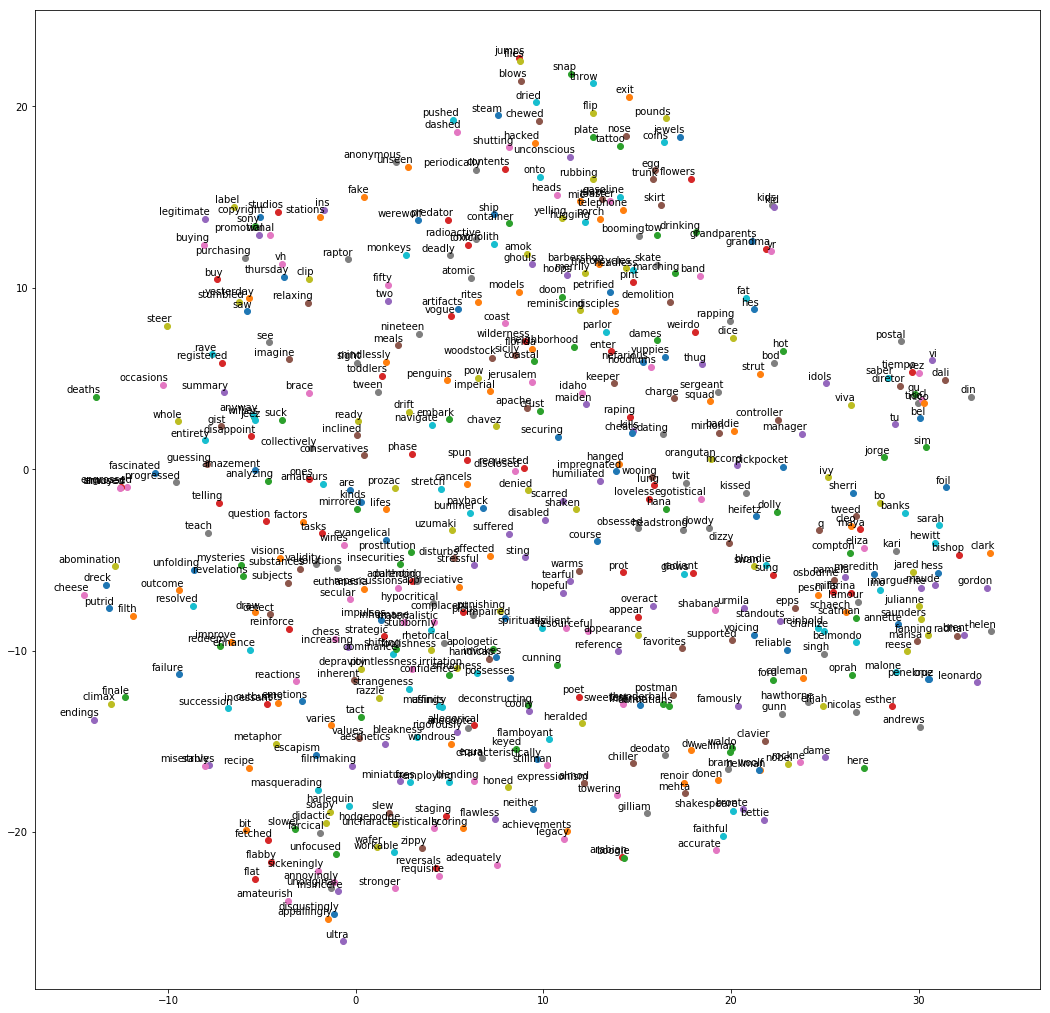

In [16]:
labels = [list(model.wv.vocab.items())[i][0] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
print("Rendered")

#list(model.wv.vocab.items())[1]

In [17]:
model.most_similar(['man'])

[('mans', 0.5435957908630371),
 ('guy', 0.5042428970336914),
 ('woman', 0.5014476776123047),
 ('men', 0.4855518341064453),
 ('chap', 0.4801918864250183),
 ('trapper', 0.45954397320747375),
 ('person', 0.45374295115470886),
 ('lad', 0.4506921172142029),
 ('bloke', 0.4438864588737488),
 ('coworker', 0.44287389516830444)]

In [18]:
model.most_similar(['girl', 'father'], ['boy'], topn=3)

[('mother', 0.5595054030418396),
 ('husband', 0.5286900997161865),
 ('mom', 0.5250003337860107)]

In [19]:
more_examples = ["laugh fun fear", "big bigger bad", "going went being"] 
for example in more_examples:
    a, b, x = example.split()
    predicted = model.most_similar([x, b], [a])[0][0]
    print (a+ " is to " + b + " as " + x + " is to " + predicted)

laugh is to fun as fear is to claustrophobia
big is to bigger as bad is to cheesier
going is to went as being is to was


### Excercise. Try vector operations

In [20]:
# Replace word1,word2,word3 with your words to see how vector operations work

model.most_similar(positive=['word1', 'word2'], negative=['word3'], topn=1)

KeyError: "word 'word1' not in vocabulary"

In [ ]:
#Replace w1 w2 w3 w4 with your words to find most improper word

model.doesnt_match("w1 w2 w3 w4".split())

In [ ]:
# Try adjectives related to sentiment to find closest words

model.most_similar("awful")

# Glove
http://www-nlp.stanford.edu/pubs/glove.pdf – Jeffrey Pennington, Richard Socher, Christopher D. Manning 2014.
http://nlp.stanford.edu/projects/glove/ – pre-trained word vectors and some theory


### What is GloVe?
*GloVe* is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
More detailed explanation https://blog.acolyer.org/2016/04/22/glove-global-vectors-for-word-representation/

![alt text](http://building-babylon.net/wp-content/uploads/2016/02/glove-matrix-factorisation-3.jpg)

### Difference with word2vec
Word2Vec and GloVe learn geometrical encodings (vectors) of words from their co-occurrence information (how frequently they appear together in large text corpora). They differ in that word2vec is a "predictive" model, whereas GloVe is a "count-based" model.

Predictive models learn their vectors in order to improve their predictive ability of Loss(target word | context words; Vectors), i.e. the loss of predicting the target words from the context words given the vector representations. In word2vec, this is cast as a feed-forward neural network and optimized as such using SGD, etc.

Count-based models learn their vectors by essentially doing dimensionality reduction on the co-occurrence counts matrix. They first construct a large matrix of (words x context) co-occurrence information, i.e. for each "word" (the rows), you count how frequently we see this word in some "context" (the columns) in a large corpus.  The number of "contexts" is of course large, since it is essentially combinatorial in size. So then they factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for each word. In general, this is done by minimizing a "reconstruction loss" which tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data. In the specific case of GloVe, the counts matrix is preprocessed by normalizing the counts and log-smoothing them. This turns out to be A Good Thing in terms of the quality of the learned representations.

However, as pointed out, when we control for all the training hyper-parameters, the embeddings generated using the two methods tend to perform very similarly in downstream NLP tasks. The additional benefits of GloVe over word2vec is that it is easier to parallelize the implementation which means it's easier to train over more data, which, with these models, is always A Good Thing.

### When to use?
Works better with neural nets, such as RNN/LSTM and CNN. On machine learning algorithms a result will be worse than on bag of words or on vectorizers.

In [24]:
text = []
HEADER = True
with open("../data/movie_reviews.csv", "r", encoding='utf-8') as file:
    if HEADER:
        header = next(file)
    for line in file:
        text.append(line.rstrip("\n").split(",", 1)[1])
print(len(text))

152610


In [25]:
import tf_glove
                       
def tokenize_comment(comment_str):
    # Use the excellent NLTK to tokenize the comment body
    #
    # Note that we're lower-casing the comments here. tf_glove is case-sensitive,
    # so if you want 'You' and 'you' to be considered the same word, be sure to lower-case everything.
    return nltk.wordpunct_tokenize(comment_str.lower())

def comment_corpus(data):
    # A generator that returns lists of tokens representing individual words in the comment
    return (tokenize_comment(comment) for comment in data)

# Replace the path with the path to your corpus file
corpus = comment_corpus(text)

# Reading the corpus

tf_glove needs to be fit to a corpus in order to learn word representations. To do this, we'll use `GloVeModel.fit_to_corpus(corpus)`. This method expects an iterable of iterables of strings, where each string is a token, like this:

`[["this", "is", "a", "comment", "."], ["this", "is", "another", "comment", "."]]`

That was a list of lists, but any iterable of iterables of strings should work.

In [ ]:
model = tf_glove.GloVeModel(embedding_size=300, context_size=10, min_occurrences=5,
                            learning_rate=0.05, batch_size=512)
model.fit_to_corpus(corpus)